In [1]:
import os, sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path
import re
from datetime import timedelta
import h5py

import utm
import math
from stl import mesh # install with `pip install numpy-stl`
from scipy.interpolate import RectBivariateSpline, griddata

In [2]:
sys.path.insert(1, '/home/sbidadi/atom/sbidadi')
from windtools.windtools.amrwind.post_processing  import Sampling

In [3]:
from windtools.windtools.plotting import plot_timeheight, plot_timehistory_at_height, plot_profile, plot_spectrum
from windtools.windtools.amrwind.post_processing  import ABLStatistics, Sampling, addDatetime

sys.path.append(os.path.abspath('/home/rthedin/repos/mmctools'))
from mmctools.helper_functions import covariance, calc_wind, calc_spectra, fit_powerlaw

sys.path.append(os.path.abspath('/home/rthedin/utilities/'))
from helper import *


In [ ]:
# ######################################### With cloud physics ###################################################

In [4]:
amrwind_x_1800_mi_po = Path('/scratch/sbidadi/oracle/oracle_sims/bc_code/case/cloud_sim_dt_fixed_abl_forcing_corr_init_condition_fine_mesh_ar_1/cloud_dx_10_mi_po_modified_v3_xlo_yhi_bc_rd/post_processing')
data_amrwind_x_1800_mi_po = Path(amrwind_x_1800_mi_po, 'box_at00000.nc')

In [ ]:
# For the following, we have sampling planes at x=0, x=1800 and y=1600 - 2hrs of simulation time

In [ ]:
amrwind_x_1800_mi_po_rd_v2 = Path('/scratch/sbidadi/oracle/oracle_sims/bc_code/case/cloud_sim_dt_fixed_abl_forcing_corr_init_condition_fine_mesh_ar_1/cloud_dx_10_mi_po_modified_v3_xlo_yhi_bc_rd_2/post_processing')
data_amrwind_x_1800_mi_po_rd_v2 = Path(amrwind_x_1800_mi_po_rd_v2, 'box_at00000.nc')

In [ ]:
data_amrwind_x_1800_mi_po_rd_v2

In [5]:
with h5py.File(data_amrwind_x_1800_mi_po) as f:
    # Time
    time0 = f['time'][9000:12000]
    time1 = f['time'][12000:15000]
    time2 = f['time'][15000:18000]
    # xz-plane
    xy_coords_raw = f['box_x_1800']['coordinates'][:]

print(np.shape(time0))
print(np.shape(xy_coords_raw))

### Reformat xz plane
xy_xcoords = np.sort(np.unique(np.round(xy_coords_raw[:,0],6)))
xy_ycoords = np.sort(np.unique(np.round(xy_coords_raw[:,1],6)))
xy_zcoords = np.sort(np.unique(np.round(xy_coords_raw[:,2],6)))

xy_coords1 = {'time':time0, 'x': xy_xcoords, 'y': xy_ycoords, 'z': xy_zcoords}
xy_coords2 = {'time':time1, 'x': xy_xcoords, 'y': xy_ycoords, 'z': xy_zcoords}
xy_coords3 = {'time':time2, 'x': xy_xcoords, 'y': xy_ycoords, 'z': xy_zcoords}

ds_yz_x_1800_mi_po_t0 = xr.Dataset(xy_coords1)
ds_yz_x_1800_mi_po_t1 = xr.Dataset(xy_coords2)
ds_yz_x_1800_mi_po_t2 = xr.Dataset(xy_coords3)


for var in ['velocityx', 'velocityy', 'velocityz', 'temperature']:
    with h5py.File(data_amrwind_x_1800_mi_po, 'r') as f:
         curr_arr1 = f['box_x_1800'][var][9000:12000,:]
         curr_arr2 = f['box_x_1800'][var][12000:15000,:]
         curr_arr3 = f['box_x_1800'][var][15000:18000,:]

#        curr_arr = f['box_x_1800'][var][:]
    arr1_reshaped = curr_arr1.reshape((len(time0), len(xy_zcoords), len(xy_ycoords), len(xy_xcoords)))
    arr2_reshaped = curr_arr2.reshape((len(time1), len(xy_zcoords), len(xy_ycoords), len(xy_xcoords)))
    arr3_reshaped = curr_arr3.reshape((len(time2), len(xy_zcoords), len(xy_ycoords), len(xy_xcoords)))
    
    arr1_transposed = np.transpose(arr1_reshaped, axes=[0,3,2,1])
    arr2_transposed = np.transpose(arr2_reshaped, axes=[0,3,2,1])
    arr3_transposed = np.transpose(arr3_reshaped, axes=[0,3,2,1])
    
    ds_yz_x_1800_mi_po_t0[var] = (('time', 'x', 'y', 'z'), arr1_transposed)
    ds_yz_x_1800_mi_po_t1[var] = (('time', 'x', 'y', 'z'), arr2_transposed)
    ds_yz_x_1800_mi_po_t2[var] = (('time', 'x', 'y', 'z'), arr3_transposed)

#ds_yz_x_1800_mi_po = xr.concat([ds_yz_x_1800_mi_po_t0, ds_yz_x_1800_mi_po_t1, ds_yz_x_1800_mi_po_t2], dim='time')
ds_yz_x_1800_mi_po = ds_yz_x_1800_mi_po_t2

(3000,)
(48640, 3)


In [6]:
ds_yz_x_1800_mi_po

<xarray.Dataset> Size: 5GB
Dimensions:      (time: 3000, x: 1, y: 320, z: 152)
Coordinates:
  * time         (time) float64 24kB 6e+03 6e+03 6.001e+03 ... 7.199e+03 7.2e+03
  * x            (x) float64 8B 1.8e+03
  * y            (y) float64 3kB 0.0 10.03 20.06 ... 3.18e+03 3.19e+03 3.2e+03
  * z            (z) float64 1kB 0.0 10.07 20.13 ... 1.5e+03 1.51e+03 1.52e+03
Data variables:
    velocityx    (time, x, y, z) float64 1GB 4.049 4.299 4.63 ... 9.482 7.11
    velocityy    (time, x, y, z) float64 1GB -4.149 -5.107 ... -0.7777 -0.5711
    velocityz    (time, x, y, z) float64 1GB 4.85e-07 -0.01261 ... 0.002915
    temperature  (time, x, y, z) float64 1GB 288.6 288.6 288.6 ... 303.6 299.7

In [ ]:
with h5py.File(data_amrwind_x_1800_mi_po_rd_v2) as f: # collect the data at x=1800m for the last 1hr of simulation time
    # Time
    time0 = f['time'][9000:12000]
    time1 = f['time'][12000:15000]
    time2 = f['time'][15000:18000]
    # xz-plane
    xy_coords_raw = f['box_x_1800']['coordinates'][:]

print(np.shape(time0))
print(np.shape(xy_coords_raw))

### Reformat xz plane
xy_xcoords = np.sort(np.unique(np.round(xy_coords_raw[:,0],6)))
xy_ycoords = np.sort(np.unique(np.round(xy_coords_raw[:,1],6)))
xy_zcoords = np.sort(np.unique(np.round(xy_coords_raw[:,2],6)))

xy_coords1 = {'time':time0, 'x': xy_xcoords, 'y': xy_ycoords, 'z': xy_zcoords}
xy_coords2 = {'time':time1, 'x': xy_xcoords, 'y': xy_ycoords, 'z': xy_zcoords}
xy_coords3 = {'time':time2, 'x': xy_xcoords, 'y': xy_ycoords, 'z': xy_zcoords}

ds_yz_x_1800_mi_po_t0 = xr.Dataset(xy_coords1)
ds_yz_x_1800_mi_po_t1 = xr.Dataset(xy_coords2)
ds_yz_x_1800_mi_po_t2 = xr.Dataset(xy_coords3)


for var in ['velocityx', 'velocityy', 'velocityz', 'temperature']:
    with h5py.File(data_amrwind_x_1800_mi_po_rd_v2, 'r') as f:
         curr_arr1 = f['box_x_1800'][var][9000:12000,:]
         curr_arr2 = f['box_x_1800'][var][12000:15000,:]
         curr_arr3 = f['box_x_1800'][var][15000:18000,:]

#        curr_arr = f['box_x_1800'][var][:]
    arr1_reshaped = curr_arr1.reshape((len(time0), len(xy_zcoords), len(xy_ycoords), len(xy_xcoords)))
    arr2_reshaped = curr_arr2.reshape((len(time1), len(xy_zcoords), len(xy_ycoords), len(xy_xcoords)))
    arr3_reshaped = curr_arr3.reshape((len(time2), len(xy_zcoords), len(xy_ycoords), len(xy_xcoords)))
    
    arr1_transposed = np.transpose(arr1_reshaped, axes=[0,3,2,1])
    arr2_transposed = np.transpose(arr2_reshaped, axes=[0,3,2,1])
    arr3_transposed = np.transpose(arr3_reshaped, axes=[0,3,2,1])
    
    ds_yz_x_1800_mi_po_t0[var] = (('time', 'x', 'y', 'z'), arr1_transposed)
    ds_yz_x_1800_mi_po_t1[var] = (('time', 'x', 'y', 'z'), arr2_transposed)
    ds_yz_x_1800_mi_po_t2[var] = (('time', 'x', 'y', 'z'), arr3_transposed)

#ds_yz_x_1800_mi_po = xr.concat([ds_yz_x_1800_mi_po_t0, ds_yz_x_1800_mi_po_t1, ds_yz_x_1800_mi_po_t2], dim='time')
ds_yz_x_1800_mi_po_rd_v2 = ds_yz_x_1800_mi_po_t2

In [ ]:
ds_yz_x_1800_mi_po_rd_v2

In [7]:
ds_yz_x_1800_mi_po = ds_yz_x_1800_mi_po.rename({'velocityx': 'u', 'velocityy': 'v', 'velocityz': 'w', 'temperature': 'T'})

In [ ]:
ds_yz_x_1800_mi_po_rd_v2 = ds_yz_x_1800_mi_po_rd_v2.rename({'velocityx': 'u', 'velocityy': 'v', 'velocityz': 'w', 'temperature': 'T'})

In [ ]:
######################################### umean ###################################
start = 6000
end = 7200
x = 1800

Nx = ds_yz_x_1800_mi_po.x.shape[0]
Ny = ds_yz_x_1800_mi_po.y.shape[0]

utot_amrwind_mi_po = []
for i in range(start, end, 1):
    tsel = i
    snapshot_amrwind = ds_yz_x_1800_mi_po.sel(time=tsel,x=x, method='nearest')
    time = float(snapshot_amrwind.time)
    utot_amrwind_mi_po.append(snapshot_amrwind['u'].values.ravel())
    
umean_amrwind_mi_po = np.mean(utot_amrwind_mi_po, axis=0)
print(umean_amrwind_mi_po.T)
print(np.size(utot_amrwind_mi_po))

######################################### vmean ###################################
vtot_amrwind_mi_po = []
for i in range(start, end, 1):
    tsel = i
    snapshot_amrwind = ds_yz_x_1800_mi_po.sel(time=tsel,x=x, method='nearest')
    time = float(snapshot_amrwind.time)
    vtot_amrwind_mi_po.append(snapshot_amrwind['v'].values.ravel())
    
vmean_amrwind_mi_po = np.mean(vtot_amrwind_mi_po, axis=0)
print(vmean_amrwind_mi_po.T)
print(np.size(vtot_amrwind_mi_po))

######################################### wmean ###################################
wtot_amrwind_mi_po = []
for i in range(start, end, 1):
    tsel = i
    snapshot_amrwind = ds_yz_x_1800_mi_po.sel(time=tsel,x=x, method='nearest')
    time = float(snapshot_amrwind.time)
    wtot_amrwind_mi_po.append(snapshot_amrwind['w'].values.ravel())
    
wmean_amrwind_mi_po = np.mean(wtot_amrwind_mi_po, axis=0)
print(wmean_amrwind_mi_po.T)
print(np.size(wtot_amrwind_mi_po))

######################################### thetalmean ###################################
thetaltot_amrwind_mi_po = []
for i in range(start, end, 1):
    tsel = i
    snapshot_amrwind = ds_yz_x_1800_mi_po.sel(time=tsel,x=x, method='nearest')
    time = float(snapshot_amrwind.time)
    thetaltot_amrwind_mi_po.append(snapshot_amrwind['T'].values.ravel())
    
thetalmean_amrwind_mi_po = np.mean(thetaltot_amrwind_mi_po, axis=0)
print(thetalmean_amrwind_mi_po.T)
print(np.size(thetaltot_amrwind_mi_po))

In [ ]:
######################################### umean ###################################
start = 0
end = 2999 #9000
x = 1800

Nx = ds_yz_x_1800_mi_po_rd_v2.x.shape[0]
Ny = ds_yz_x_1800_mi_po_rd_v2.y.shape[0]

utot_amrwind_mi_po_rd_v2 = []
for i in range(start, end, 1):
    tsel = i
    snapshot_amrwind = ds_yz_x_1800_mi_po_rd_v2.isel(time=tsel,x=0)
    time = float(snapshot_amrwind.time)
    utot_amrwind_mi_po_rd_v2.append(snapshot_amrwind['u'].values.ravel())
    
umean_amrwind_mi_po_rd_v2 = np.mean(utot_amrwind_mi_po_rd_v2, axis=0)

######################################### vmean ###################################
vtot_amrwind_mi_po_rd_v2 = []
for i in range(start, end, 1):
    tsel = i
    snapshot_amrwind = ds_yz_x_1800_mi_po_rd_v2.sel(time=tsel,x=x, method='nearest')
    time = float(snapshot_amrwind.time)
    vtot_amrwind_mi_po_rd_v2.append(snapshot_amrwind['v'].values.ravel())
    
vmean_amrwind_mi_po_rd_v2 = np.mean(vtot_amrwind_mi_po_rd_v2, axis=0)

######################################### wmean ###################################
wtot_amrwind_mi_po_rd_v2 = []
for i in range(start, end, 1):
    tsel = i
    snapshot_amrwind = ds_yz_x_1800_mi_po_rd_v2.sel(time=tsel,x=x, method='nearest')
    time = float(snapshot_amrwind.time)
    wtot_amrwind_mi_po_rd_v2.append(snapshot_amrwind['w'].values.ravel())
    
wmean_amrwind_mi_po_rd_v2 = np.mean(wtot_amrwind_mi_po_rd_v2, axis=0)

######################################### thetalmean ###################################
thetaltot_amrwind_mi_po_rd_v2 = []
for i in range(start, end, 1):
    tsel = i
    snapshot_amrwind = ds_yz_x_1800_mi_po_rd_v2.sel(time=tsel,x=x, method='nearest')
    time = float(snapshot_amrwind.time)
    thetaltot_amrwind_mi_po_rd_v2.append(snapshot_amrwind['T'].values.ravel())
    
thetalmean_amrwind_mi_po_rd_v2 = np.mean(thetaltot_amrwind_mi_po_rd_v2, axis=0)

In [ ]:
######################### At y = 1600m ##################

In [ ]:
data_amrwind_y_1600_mi_po = Path(amrwind_x_1800_mi_po, 'box_y00000.nc')

In [ ]:
data_amrwind_y_1600_mi_po_rd_v2 = Path(amrwind_x_1800_mi_po_rd_v2, 'box_y00000.nc')

In [ ]:
with h5py.File(data_amrwind_y_1600_mi_po_rd_v2) as f:
    # Time
    time0 = f['time'][9000:12000]
    time1 = f['time'][12000:15000]
    time2 = f['time'][9000:18000]
    # xz-plane
    xz_coords_raw = f['box_y_1600']['coordinates'][:]

print(np.shape(time0))
print(np.shape(xy_coords_raw))

### Reformat xz plane
xz_xcoords = np.sort(np.unique(np.round(xz_coords_raw[:,0],6)))
xz_ycoords = np.sort(np.unique(np.round(xz_coords_raw[:,1],6)))
xz_zcoords = np.sort(np.unique(np.round(xz_coords_raw[:,2],6)))

xz_coords1 = {'time':time0, 'x': xz_xcoords, 'y': xz_ycoords, 'z': xz_zcoords}
xz_coords2 = {'time':time1, 'x': xz_xcoords, 'y': xz_ycoords, 'z': xz_zcoords}
xz_coords3 = {'time':time2, 'x': xz_xcoords, 'y': xz_ycoords, 'z': xz_zcoords}

ds_xz_y_1600_mi_po_t0 = xr.Dataset(xz_coords1)
ds_xz_y_1600_mi_po_t1 = xr.Dataset(xz_coords2)
ds_xz_y_1600_mi_po_t2 = xr.Dataset(xz_coords3)

for var in ['velocityx', 'velocityy', 'velocityz', 'temperature']:
    with h5py.File(data_amrwind_y_1600_mi_po_rd_v2, 'r') as f:
         curr_arr1 = f['box_y_1600'][var][9000:12000,:]
         curr_arr2 = f['box_y_1600'][var][12000:15000,:]
         curr_arr3 = f['box_y_1600'][var][9000:18000,:]

#        curr_arr = f['box_x_1800'][var][:]
    arr1_reshaped = curr_arr1.reshape((len(time0), len(xz_zcoords), len(xz_ycoords), len(xz_xcoords)))
    arr2_reshaped = curr_arr2.reshape((len(time1), len(xz_zcoords), len(xz_ycoords), len(xz_xcoords)))
    arr3_reshaped = curr_arr3.reshape((len(time2), len(xz_zcoords), len(xz_ycoords), len(xz_xcoords)))
    
    arr1_transposed = np.transpose(arr1_reshaped, axes=[0,3,2,1])
    arr2_transposed = np.transpose(arr2_reshaped, axes=[0,3,2,1])
    arr3_transposed = np.transpose(arr3_reshaped, axes=[0,3,2,1])
    
    ds_xz_y_1600_mi_po_t0[var] = (('time', 'x', 'y', 'z'), arr1_transposed)
    ds_xz_y_1600_mi_po_t1[var] = (('time', 'x', 'y', 'z'), arr2_transposed)
    ds_xz_y_1600_mi_po_t2[var] = (('time', 'x', 'y', 'z'), arr3_transposed)

#ds_yz_x_1800_mi_po = xr.concat([ds_yz_x_1800_mi_po_t0, ds_yz_x_1800_mi_po_t1, ds_yz_x_1800_mi_po_t2], dim='time')
ds_xz_y_1600_mi_po_rd_v2 = ds_xz_y_1600_mi_po_t2

In [ ]:
ds_xz_y_1600_mi_po_rd_v2 = ds_xz_y_1600_mi_po_rd_v2.rename({'velocityx': 'u', 'velocityy': 'v', 'velocityz': 'w', 'temperature': 'T'})

In [ ]:
################################################################################################################
# ######################################### No cloud physics ###################################################
################################################################################################################

In [8]:
amrwind_x_1800_mi_po_nc = Path('/scratch/sbidadi/oracle/oracle_sims/bc_code/case/cloud_sim_dt_fixed_abl_forcing_corr_init_condition_fine_mesh_ar_1/no_cloud_dx_10_mi_po_modified_v3_xlo_yhi_bc_rd/post_processing')
data_amrwind_x_1800_mi_po_nc = Path(amrwind_x_1800_mi_po_nc, 'box_at00000.nc')

In [9]:
with h5py.File(data_amrwind_x_1800_mi_po_nc) as f:
    # Time
    time0 = f['time'][9000:12000]
    time1 = f['time'][12000:15000]
    time2 = f['time'][15000:18000]
    # xz-plane
    xy_coords_raw = f['box_x_1800']['coordinates'][:]

print(np.shape(time0))
print(np.shape(xy_coords_raw))

### Reformat xz plane
xy_xcoords = np.sort(np.unique(np.round(xy_coords_raw[:,0],6)))
xy_ycoords = np.sort(np.unique(np.round(xy_coords_raw[:,1],6)))
xy_zcoords = np.sort(np.unique(np.round(xy_coords_raw[:,2],6)))

xy_coords1 = {'time':time0, 'x': xy_xcoords, 'y': xy_ycoords, 'z': xy_zcoords}
xy_coords2 = {'time':time1, 'x': xy_xcoords, 'y': xy_ycoords, 'z': xy_zcoords}
xy_coords3 = {'time':time2, 'x': xy_xcoords, 'y': xy_ycoords, 'z': xy_zcoords}

ds_yz_x_1800_mi_po_nc_t0 = xr.Dataset(xy_coords1)
ds_yz_x_1800_mi_po_nc_t1 = xr.Dataset(xy_coords2)
ds_yz_x_1800_mi_po_nc_t2 = xr.Dataset(xy_coords3)


for var in ['velocityx', 'velocityy', 'velocityz', 'temperature']:
    with h5py.File(data_amrwind_x_1800_mi_po_nc, 'r') as f:
         curr_arr1 = f['box_x_1800'][var][9000:12000,:]
         curr_arr2 = f['box_x_1800'][var][12000:15000,:]
         curr_arr3 = f['box_x_1800'][var][15000:18000,:]

#        curr_arr = f['box_x_1800'][var][:]
    arr1_reshaped = curr_arr1.reshape((len(time0), len(xy_zcoords), len(xy_ycoords), len(xy_xcoords)))
    arr2_reshaped = curr_arr2.reshape((len(time1), len(xy_zcoords), len(xy_ycoords), len(xy_xcoords)))
    arr3_reshaped = curr_arr3.reshape((len(time2), len(xy_zcoords), len(xy_ycoords), len(xy_xcoords)))
    
    arr1_transposed = np.transpose(arr1_reshaped, axes=[0,3,2,1])
    arr2_transposed = np.transpose(arr2_reshaped, axes=[0,3,2,1])
    arr3_transposed = np.transpose(arr3_reshaped, axes=[0,3,2,1])
    
    ds_yz_x_1800_mi_po_nc_t0[var] = (('time', 'x', 'y', 'z'), arr1_transposed)
    ds_yz_x_1800_mi_po_nc_t1[var] = (('time', 'x', 'y', 'z'), arr2_transposed)
    ds_yz_x_1800_mi_po_nc_t2[var] = (('time', 'x', 'y', 'z'), arr3_transposed)

#ds_yz_x_1800_mi_po_nc = xr.concat([ds_yz_x_1800_mi_po_nc_t0, ds_yz_x_1800_mi_po_nc_t1, ds_yz_x_1800_mi_po_nc_t2], dim='time')

(3000,)
(48640, 3)


In [10]:
ds_yz_x_1800_mi_po_nc_t2 = ds_yz_x_1800_mi_po_nc_t2.rename({'velocityx': 'u', 'velocityy': 'v', 'velocityz': 'w', 'temperature': 'T'})

In [11]:
ds_yz_x_1800_mi_po_nc_t2

<xarray.Dataset> Size: 5GB
Dimensions:  (time: 3000, x: 1, y: 320, z: 152)
Coordinates:
  * time     (time) float64 24kB 6e+03 6e+03 6.001e+03 ... 7.199e+03 7.2e+03
  * x        (x) float64 8B 1.8e+03
  * y        (y) float64 3kB 0.0 10.03 20.06 30.09 ... 3.18e+03 3.19e+03 3.2e+03
  * z        (z) float64 1kB 0.0 10.07 20.13 30.2 ... 1.5e+03 1.51e+03 1.52e+03
Data variables:
    u        (time, x, y, z) float64 1GB 3.768 3.88 3.947 ... 9.55 9.66 7.259
    v        (time, x, y, z) float64 1GB -4.463 -5.447 -6.283 ... -0.968 -0.7709
    w        (time, x, y, z) float64 1GB -0.0224 -0.1052 ... -0.102 -0.0542
    T        (time, x, y, z) float64 1GB 288.4 288.4 288.4 ... 303.8 303.8 299.9

In [ ]:
data_amrwind_y_1600_mi_po_nc = Path(amrwind_x_1800_mi_po_nc, 'box_y00000.nc')

In [ ]:
with h5py.File(data_amrwind_y_1600_mi_po_nc) as f:
    # Time
    time0 = f['time'][9000:12000]
    time1 = f['time'][12000:15000]
    time2 = f['time'][15000:18000]
    # xz-plane
    xz_coords_raw = f['box_y_1600']['coordinates'][:]

print(np.shape(time0))
print(np.shape(xz_coords_raw))

### Reformat xz plane
xz_xcoords = np.sort(np.unique(np.round(xz_coords_raw[:,0],6)))
xz_ycoords = np.sort(np.unique(np.round(xz_coords_raw[:,1],6)))
xz_zcoords = np.sort(np.unique(np.round(xz_coords_raw[:,2],6)))

xz_coords1 = {'time':time0, 'x': xz_xcoords, 'y': xz_ycoords, 'z': xy_zcoords}
xz_coords2 = {'time':time1, 'x': xz_xcoords, 'y': xz_ycoords, 'z': xy_zcoords}
xz_coords3 = {'time':time2, 'x': xz_xcoords, 'y': xz_ycoords, 'z': xy_zcoords}

ds_xz_y_1600_mi_po_nc_t0 = xr.Dataset(xz_coords1)
ds_xz_y_1600_mi_po_nc_t1 = xr.Dataset(xz_coords2)
ds_xz_y_1600_mi_po_nc_t2 = xr.Dataset(xz_coords3)

for var in ['velocityx', 'velocityy', 'velocityz', 'temperature']:
    with h5py.File(data_amrwind_y_1600_mi_po_nc, 'r') as f:
         curr_arr1 = f['box_y_1600'][var][9000:12000,:]
         curr_arr2 = f['box_y_1600'][var][12000:15000,:]
         curr_arr3 = f['box_y_1600'][var][15000:18000,:]

#        curr_arr = f['box_x_1800'][var][:]
    arr1_reshaped = curr_arr1.reshape((len(time0), len(xz_zcoords), len(xz_ycoords), len(xz_xcoords)))
    arr2_reshaped = curr_arr2.reshape((len(time1), len(xz_zcoords), len(xz_ycoords), len(xz_xcoords)))
    arr3_reshaped = curr_arr3.reshape((len(time2), len(xz_zcoords), len(xz_ycoords), len(xz_xcoords)))
    
    arr1_transposed = np.transpose(arr1_reshaped, axes=[0,3,2,1])
    arr2_transposed = np.transpose(arr2_reshaped, axes=[0,3,2,1])
    arr3_transposed = np.transpose(arr3_reshaped, axes=[0,3,2,1])
    
    ds_xz_y_1600_mi_po_nc_t0[var] = (('time', 'x', 'y', 'z'), arr1_transposed)
    ds_xz_y_1600_mi_po_nc_t1[var] = (('time', 'x', 'y', 'z'), arr2_transposed)
    ds_xz_y_1600_mi_po_nc_t2[var] = (('time', 'x', 'y', 'z'), arr3_transposed)

#ds_yz_x_1800_mi_po_nc = xr.concat([ds_yz_x_1800_mi_po_nc_t0, ds_yz_x_1800_mi_po_nc_t1, ds_yz_x_1800_mi_po_nc_t2], dim='time')

In [ ]:
ds_xz_y_1600_mi_po_nc_t2 = ds_xz_y_1600_mi_po_nc_t2.rename({'velocityx': 'u', 'velocityy': 'v', 'velocityz': 'w', 'temperature': 'T'})

In [ ]:
######################################### umean ###################################
start = 0
end = 2999
x = 1800

Nx = ds_yz_x_1800_mi_po_nc_t2.x.shape[0]
Ny = ds_yz_x_1800_mi_po_nc_t2.y.shape[0]

utot_amrwind_mi_po_nc = []
for i in range(start, end, 1):
    tsel = i
    snapshot_amrwind_nc = ds_yz_x_1800_mi_po_nc_t2.isel(time=tsel,x=0)
    time = float(snapshot_amrwind_nc.time)
    utot_amrwind_mi_po_nc.append(snapshot_amrwind_nc['u'].values.ravel())
    
umean_amrwind_mi_po_nc = np.mean(utot_amrwind_mi_po_nc, axis=0)
print(umean_amrwind_mi_po_nc.T)
print(np.size(utot_amrwind_mi_po_nc))

######################################### vmean ###################################
vtot_amrwind_mi_po_nc = []
for i in range(start, end, 1):
    tsel = i
    snapshot_amrwind_nc = ds_yz_x_1800_mi_po_nc_t2.sel(time=tsel,x=x, method='nearest')
    time = float(snapshot_amrwind_nc.time)
    vtot_amrwind_mi_po_nc.append(snapshot_amrwind_nc['v'].values.ravel())
    
vmean_amrwind_mi_po_nc = np.mean(vtot_amrwind_mi_po_nc, axis=0)
print(vmean_amrwind_mi_po_nc.T)
print(np.size(vtot_amrwind_mi_po_nc))

######################################### wmean ###################################
wtot_amrwind_mi_po_nc = []
for i in range(start, end, 1):
    tsel = i
    snapshot_amrwind_nc = ds_yz_x_1800_mi_po_nc_t2.sel(time=tsel,x=x, method='nearest')
    time = float(snapshot_amrwind_nc.time)
    wtot_amrwind_mi_po_nc.append(snapshot_amrwind_nc['w'].values.ravel())
    
wmean_amrwind_mi_po_nc = np.mean(wtot_amrwind_mi_po_nc, axis=0)
print(wmean_amrwind_mi_po_nc.T)
print(np.size(wtot_amrwind_mi_po_nc))

######################################### thetalmean ###################################
thetaltot_amrwind_mi_po_nc = []
for i in range(start, end, 1):
    tsel = i
    snapshot_amrwind_nc = ds_yz_x_1800_mi_po_nc_t2.sel(time=tsel,x=x, method='nearest')
    time = float(snapshot_amrwind_nc.time)
    thetaltot_amrwind_mi_po_nc.append(snapshot_amrwind_nc['T'].values.ravel())
    
thetalmean_amrwind_mi_po_nc = np.mean(thetaltot_amrwind_mi_po_nc, axis=0)
print(thetalmean_amrwind_mi_po_nc.T)
print(np.size(thetaltot_amrwind_mi_po_nc))

In [ ]:
############################################### Plots ###############################################

In [ ]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2 
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 18.0

print(wmean_amrwind_mi_po_rd_v2.size)

fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(15,5),squeeze=False)
cmap = plt.colormaps['jet']

yy,zz = np.meshgrid(ds_yz_x_1800_mi_po_rd_v2.y, ds_yz_x_1800_mi_po_rd_v2.z, indexing='ij')
wmean_rd_v2 = axs[0,0].pcolormesh(yy, zz, snapshot_amrwind['w'], cmap=cmap)
wmean_rd_v2.set_array(wmean_amrwind_mi_po_rd_v2)
axs[0,0].set_xlabel("y (m)")
axs[0,0].set_ylabel("z (m)")
axs[0,0].set_title("w velocity contour at x=1800m")
cbar_rd_v2 = fig.colorbar(wmean_rd_v2, ax=axs[0,0])

In [ ]:
ds_yz_x_1800_mi_po_rd_v2

In [ ]:
ds_xz_y_1600_mi_po_rd_v2

In [ ]:
# At x = 1800m, get data to plot w vs.z at different y locations
ds_w = ds_yz_x_1800_mi_po_rd_v2['w']
w_0 = (ds_w.isel(x=0, y=0)).mean(dim='time') # y = 0m
w_500 = (ds_w.isel(x=0, y=50)).mean(dim='time') # y = 0m
w_1000 = (ds_w.isel(x=0, y=100)).mean(dim='time') # y = 1000m
w_2000 = (ds_w.isel(x=0, y=200)).mean(dim='time') # y = 2000m
w_3000 = (ds_w.isel(x=0, y=300)).mean(dim='time') # y = 3000m
w_3100 = (ds_w.isel(x=0, y=310)).mean(dim='time') # y = 3100m
w_3200 = (ds_w.isel(x=0, y=319)).mean(dim='time') # y = 3200m

# At y = 1600m, get data to plot w vs.z at different y locations
ds_w_y_1600 = ds_xz_y_1600_mi_po_rd_v2['w']
w_0_y_1600 = (ds_w_y_1600.isel(y=0, x=0)).mean(dim='time') # x = 0m
w_500_y_1600 = (ds_w_y_1600.isel(y=0, x=50)).mean(dim='time') # x = 500m
w_1000_y_1600 = (ds_w_y_1600.isel(y=0, x=100)).mean(dim='time') # x = 1000m
w_2000_y_1600 = (ds_w_y_1600.isel(y=0, x=200)).mean(dim='time') # x = 2000m
w_3000_y_1600 = (ds_w_y_1600.isel(y=0, x=300)).mean(dim='time') # x = 3000m
w_3100_y_1600 = (ds_w_y_1600.isel(y=0, x=310)).mean(dim='time') # x = 3100m
w_3200_y_1600 = (ds_w_y_1600.isel(y=0, x=319)).mean(dim='time') # x = 3200m

In [ ]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2 
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 8.0

plt.figure()
plt.grid()
plt.plot(w_3200, ds_yz_x_1800_mi_po_rd_v2.z,linewidth=3, label='y=3200m')
plt.plot(w_3100, ds_yz_x_1800_mi_po_rd_v2.z,linewidth=3, label='y=3100m')
plt.plot(w_3000, ds_yz_x_1800_mi_po_rd_v2.z,linewidth=3, label='y=3000m')
plt.plot(w_2000, ds_yz_x_1800_mi_po_rd_v2.z,linewidth=3, label='y=2000m')
plt.plot(w_1000, ds_yz_x_1800_mi_po_rd_v2.z,linewidth=3, label='y=1000m')
plt.plot(w_500, ds_yz_x_1800_mi_po_rd_v2.z,linewidth=3, label='y=500m')
plt.plot(w_0, ds_yz_x_1800_mi_po_rd_v2.z,linewidth=3, label='y=0m')
plt.vlines(x=0, ymin=-2.0, ymax=2000.0, color='k', alpha=0.7, linestyle='--')
plt.xlabel(r'$\overline{w}$ (m/s)')
plt.ylabel('z (m)')
#plt.xlim([5.0,13.0])
plt.ylim([0.0,1530.0])
plt.legend()
plt.title("At x=1800m")

plt.figure()
plt.grid()
plt.plot(w_0_y_1600, ds_yz_x_1800_mi_po_rd_v2.z,linewidth=3, label='x=0m')
plt.plot(w_500_y_1600, ds_yz_x_1800_mi_po_rd_v2.z,linewidth=3, label='x=500m')
plt.plot(w_1000_y_1600, ds_yz_x_1800_mi_po_rd_v2.z,linewidth=3, label='x=1000m')
plt.plot(w_2000_y_1600, ds_yz_x_1800_mi_po_rd_v2.z,linewidth=3, label='x=2000m')
plt.plot(w_3000_y_1600, ds_yz_x_1800_mi_po_rd_v2.z,linewidth=3, label='x=3000m')
plt.plot(w_3100_y_1600, ds_yz_x_1800_mi_po_rd_v2.z,linewidth=3, label='x=3100m')
plt.plot(w_3200_y_1600, ds_yz_x_1800_mi_po_rd_v2.z,linewidth=3, label='x=3200m')
plt.vlines(x=0, ymin=-2.0, ymax=2000.0, color='k', alpha=0.7, linestyle='--')
plt.xlabel(r'$\overline{w}$ (m/s)')
plt.ylabel('z (m)')
#plt.xlim([5.0,13.0])
plt.ylim([0.0,1530.0])
plt.legend()
plt.title("At y=1600m")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of vertical cells
n_cells = 5

# Cell height (meters)
dz = 1.0

# Initialize arrays for u and v velocities at west, east, south, north faces for each cell
# Linearly increasing u from 5.0 to 10.0 m/s over 5 cells (east - west diff = 1 m/s per cell)
u_west = 5.0 + np.arange(n_cells)  # u_west at each cell layer bottom face
u_east = u_west + 1.0              # east face 1 m/s greater than west face

# v goes from -0.5 to 0 linearly over 5 cells (north - south diff changes from 0.5 to 0)
v_south = -0.5 + np.arange(n_cells) * 0.1  # increases by 0.1 m/s per cell
v_north = np.minimum(v_south + 0.5, 0.0)  # north face v up to 0 but limited to max 0

# Bottom vertical velocity w at lowest face is zero due to wall
w_faces = [0.0]  # w at cell bottom boundary face

# Cell face area assumed 1 m^2
A = 1.0

# Calculate w at top faces by integrating horizontal divergence upward
for k in range(n_cells):
    # Horizontal flux difference for cell k
    horizontal_flux = (u_east[k] - u_west[k]) * A + (v_north[k] - v_south[k]) * A

    # Vertical velocity at top face from continuity (negative horizontal outflow balanced by vertical inflow)
    w_top = w_faces[-1] - horizontal_flux * dz  # dz factor included for volume

    w_faces.append(w_top)

# Mid cell heights at face midpoints
z_faces = np.arange(n_cells + 1) * dz

# Plotting
plt.figure(figsize=(6,6))
plt.plot(w_faces, z_faces, marker='o')
plt.xlabel('Vertical velocity w (m/s)')
plt.ylabel('Height z (m)')
plt.title('Vertical velocity profile w vs z above the capping inversion')
plt.grid(True)
plt.gca().invert_yaxis()  # Optional: invert y-axis if height zero is at bottom
plt.show()


In [ ]:
Ny = ds_yz_x_1800_mi_po_rd_v2.y.shape[0]
Nz = ds_yz_x_1800_mi_po_rd_v2.z.shape[0]

wmean_rd_v2_mesh_data = wmean_rd_v2.get_array()
wdata_rd_v2_mesh_data_rs = wmean_rd_v2_mesh_data.reshape(Ny, Nz)
wmean_rd_v2_vs_z = np.mean(wdata_rd_v2_mesh_data_rs, axis=0)

print(wmean_rd_v2_vs_z)
plt.figure()
plt.grid()
plt.plot(wmean_rd_v2_vs_z, ds_yz_x_1800_mi_po_rd_v2.z,linewidth=3, label='RD-2')
plt.xlabel(r'$\overline{w}$ (m/s)')
plt.ylabel('z (m)')
plt.legend()

In [ ]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2 
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 18.0

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5),squeeze=False)
cmap = plt.colormaps['jet']

# yy,zz = np.meshgrid(ds_yz_x_1800_mi_po.y, ds_yz_x_1800_mi_po.z, indexing='ij')
# wmean = axs[0,0].pcolormesh(yy, zz, snapshot_amrwind['w'], cmap=cmap)
# wmean.set_array(wmean_amrwind_mi_po)
# axs[0,0].set_xlabel("y (m)")
# axs[0,0].set_ylabel("z (m)")
# axs[0,0].set_title("RD ")
# cbar = fig.colorbar(wmean, ax=axs[0,0])

yy,zz = np.meshgrid(ds_yz_x_1800_mi_po_rd_v2.y, ds_yz_x_1800_mi_po_rd_v2.z, indexing='ij')
wmean_rd_v2 = axs[0,1].pcolormesh(yy, zz, snapshot_amrwind['w'], cmap=cmap)
wmean_rd_v2.set_array(wmean_amrwind_mi_po_rd_v2)
axs[0,1].set_xlabel("y (m)")
axs[0,1].set_ylabel("z (m)")
axs[0,1].set_title("RD 2")
cbar_rd_v2 = fig.colorbar(wmean_rd_v2, ax=axs[0,1])

In [ ]:
Ny = ds_yz_x_1800_mi_po.y.shape[0]
Nz = ds_yz_x_1800_mi_po.z.shape[0]

wmean_mesh_data = wmean.get_array()
wdata_mesh_data_rs = wmean_mesh_data.reshape(Ny, Nz)
print(wdata_mesh_data_rs.shape)
wmean_vs_z = np.mean(wdata_mesh_data_rs, axis=0)

wmean_rd_v2_mesh_data = wmean_rd_v2.get_array()
wdata_rd_v2_mesh_data_rs = wmean_mesh_data.reshape(Ny, Nz)
wmean_rd_v2_vs_z = np.mean(wdata_rd_v2_mesh_data_rs, axis=0)

print(wmean_vs_z)
print(wmean_rd_v2_vs_z)
plt.figure()
plt.grid()
plt.plot(wmean_vs_z, ds_yz_x_1800_mi_po.z,linewidth=3, label='RD')
plt.plot(wmean_rd_v2_vs_z, ds_yz_x_1800_mi_po.z,linewidth=3, label='RD-2')
plt.xlabel(r'$\overline{w}$ (m/s)')
plt.ylabel('z (m)')
plt.legend()

In [ ]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2 
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 18.0

fig, axs = plt.subplots(nrows=4,ncols=2,figsize=(30,30),squeeze=False)
cmap = plt.colormaps['jet']

yy_aw,zz_aw = np.meshgrid(ds_yz_x_1800_mi_po.y, ds_yz_x_1800_mi_po.z, indexing='ij')
#fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5),squeeze=False)
#cmap = plt.colormaps['jet']
umean_aw_nc = axs[0,0].pcolormesh(yy_aw, zz_aw, snapshot_amrwind_nc['u'], cmap=cmap)
umean_aw_nc.set_array(umean_amrwind_mi_po_nc)
axs[0,0].set_xlabel("y (m)")
axs[0,0].set_ylabel("z (m)")
axs[0,0].set_title("No clouds")
cbar_aw_nc = fig.colorbar(umean_aw_nc, ax=axs[0,0])

yy_aw,zz_aw = np.meshgrid(ds_yz_x_1800_mi_po.y, ds_yz_x_1800_mi_po.z, indexing='ij')
#fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5),squeeze=False)
#cmap = plt.colormaps['jet']
umean_aw = axs[0,1].pcolormesh(yy_aw, zz_aw, snapshot_amrwind['u'], cmap=cmap)
umean_aw.set_array(umean_amrwind_mi_po)
axs[0,1].set_xlabel("y (m)")
axs[0,1].set_ylabel("z (m)")
axs[0,1].set_title("With clouds")
cbar_aw = fig.colorbar(umean_aw, ax=axs[0,1])

print(cbar_aw_nc.vmin)
print(cbar_aw_nc.vmax)

print(cbar_aw.vmin)
print(cbar_aw.vmax)


####

print("")
yy_aw,zz_aw = np.meshgrid(ds_yz_x_1800_mi_po.y, ds_yz_x_1800_mi_po.z, indexing='ij')
vmean_aw_nc = axs[1,0].pcolormesh(yy_aw, zz_aw, snapshot_amrwind_nc['v'], cmap=cmap)
vmean_aw_nc.set_array(vmean_amrwind_mi_po_nc)
axs[1,0].set_xlabel("y (m)")
axs[1,0].set_ylabel("z (m)")
axs[1,0].set_title("No clouds")
cbar_aw_nc = fig.colorbar(vmean_aw_nc, ax=axs[1,0])

yy_aw,zz_aw = np.meshgrid(ds_yz_x_1800_mi_po.y, ds_yz_x_1800_mi_po.z, indexing='ij')
vmean_aw = axs[1,1].pcolormesh(yy_aw, zz_aw, snapshot_amrwind['v'], cmap=cmap)
vmean_aw.set_array(vmean_amrwind_mi_po)
axs[1,1].set_xlabel("y (m)")
axs[1,1].set_ylabel("z (m)")
axs[1,1].set_title("With clouds")
cbar_aw = fig.colorbar(vmean_aw, ax=axs[1,1])

print(cbar_aw_nc.vmin)
print(cbar_aw_nc.vmax)

print(cbar_aw.vmin)
print(cbar_aw.vmax)

####

print("")
yy_aw,zz_aw = np.meshgrid(ds_yz_x_1800_mi_po.y, ds_yz_x_1800_mi_po.z, indexing='ij')
wmean_aw_nc = axs[2,0].pcolormesh(yy_aw, zz_aw, snapshot_amrwind_nc['w'], cmap=cmap)
wmean_aw_nc.set_array(wmean_amrwind_mi_po_nc)
axs[2,0].set_xlabel("y (m)")
axs[2,0].set_ylabel("z (m)")
axs[2,0].set_title("No clouds")
cbar_aw_nc = fig.colorbar(wmean_aw_nc, ax=axs[2,0])
print(cbar_aw_nc.vmin)
print(cbar_aw_nc.vmax)


yy_aw,zz_aw = np.meshgrid(ds_yz_x_1800_mi_po.y, ds_yz_x_1800_mi_po.z, indexing='ij')
wmean_aw = axs[2,1].pcolormesh(yy_aw, zz_aw, snapshot_amrwind['w'], cmap=cmap)
wmean_aw.set_array(wmean_amrwind_mi_po)
axs[2,1].set_xlabel("y (m)")
axs[2,1].set_ylabel("z (m)")
axs[2,1].set_title("With clouds")
cbar_aw = fig.colorbar(wmean_aw, ax=axs[2,1])
print(cbar_aw.vmin)
print(cbar_aw.vmax)


###

print("")

yy_aw,zz_aw = np.meshgrid(ds_yz_x_1800_mi_po.y, ds_yz_x_1800_mi_po.z, indexing='ij')
thetalmean_aw_nc = axs[3,0].pcolormesh(yy_aw, zz_aw, snapshot_amrwind_nc['T'], cmap=cmap)
thetalmean_aw_nc.set_array(thetalmean_amrwind_mi_po_nc)
axs[3,0].set_xlabel("y (m)")
axs[3,0].set_ylabel("z (m)")
axs[3,0].set_title("AMR-Wind - mipo - ydir")
cbar_aw_nc = fig.colorbar(thetalmean_aw_nc, ax=axs[3,0])
print(cbar_aw_nc.vmin)
print(cbar_aw_nc.vmax)

yy_aw,zz_aw = np.meshgrid(ds_yz_x_1800_mi_po.y, ds_yz_x_1800_mi_po.z, indexing='ij')
thetalmean_aw = axs[3,1].pcolormesh(yy_aw, zz_aw, snapshot_amrwind['T'], cmap=cmap)
thetalmean_aw.set_array(thetalmean_amrwind_mi_po)
axs[3,1].set_xlabel("y (m)")
axs[3,1].set_ylabel("z (m)")
axs[3,1].set_title("AMR-Wind - mipo - ydir")
cbar_aw = fig.colorbar(thetalmean_aw, ax=axs[3,1])
print(cbar_aw.vmin)
print(cbar_aw.vmax)

In [ ]:
ds_yz_x_1800_mi_po

In [ ]:
# turbulence intensity

ds_x_0 = ds_yz_x_1800_mi_po.isel(x=0)
ds_x_0['uv'] = ds_x_0.var(dim=['time'])['uv']
# ds_x_0['vv'] = ds_x_0.var(dim=['time'])['v']
# ds_x_0['ww'] = ds_x_0.var(dim=['time'])['w']
#ds_x_0['TKE'] = 0.5*(ds_z_0['uu'] + ds_z_0['vv'] + ds_z_0['ww'])

# xx, yy = np.meshgrid(ds_z_0.x, ds_z_0.y, indexing='ij')
# fig, ax = plt.subplots(1,1,figsize=(12,8))
# ax.set_xlabel("x")
# ax.set_ylabel("y")

# cm = ax.pcolormesh(xx, yy, ds_z_0['TKE'],cmap=cmap)
# fig.colorbar(cm, ax=ax,location="top")
# fig.gca().set_aspect('equal')

In [ ]:
# No clouds
Ny = ds_yz_x_1800_mi_po.y.shape[0]
Nz = ds_yz_x_1800_mi_po.z.shape[0]

umean_aw_mesh_data_nc = umean_aw_nc.get_array()
udata_aw_mesh_data_rs_nc = umean_aw_mesh_data_nc.reshape(Ny, Nz)
umean_amrwind_vs_z_nc = np.mean(udata_aw_mesh_data_rs_nc, axis=0)

vmean_aw_mesh_data_nc = vmean_aw_nc.get_array()
vdata_aw_mesh_data_rs_nc = vmean_aw_mesh_data_nc.reshape(Ny, Nz)
vmean_amrwind_vs_z_nc = np.mean(vdata_aw_mesh_data_rs_nc, axis=0)

wmean_aw_mesh_data_nc = wmean_aw_nc.get_array()
wdata_aw_mesh_data_rs_nc = wmean_aw_mesh_data_nc.reshape(Ny, Nz)
wmean_amrwind_vs_z_nc = np.mean(wdata_aw_mesh_data_rs_nc, axis=0)

thetalmean_aw_mesh_data_nc = thetalmean_aw_nc.get_array()
thetaldata_aw_mesh_data_rs_nc = thetalmean_aw_mesh_data_nc.reshape(Ny, Nz)
thetalmean_amrwind_vs_z_nc = np.mean(thetaldata_aw_mesh_data_rs_nc, axis=0)

# With clouds
Ny = ds_yz_x_1800_mi_po.y.shape[0]
Nz = ds_yz_x_1800_mi_po.z.shape[0]

umean_aw_mesh_data = umean_aw.get_array()
udata_aw_mesh_data_rs = umean_aw_mesh_data.reshape(Ny, Nz)
umean_amrwind_vs_z = np.mean(udata_aw_mesh_data_rs, axis=0)

vmean_aw_mesh_data = vmean_aw.get_array()
vdata_aw_mesh_data_rs = vmean_aw_mesh_data.reshape(Ny, Nz)
vmean_amrwind_vs_z = np.mean(vdata_aw_mesh_data_rs, axis=0)

wmean_aw_mesh_data = wmean_aw.get_array()
wdata_aw_mesh_data_rs = wmean_aw_mesh_data.reshape(Ny, Nz)
wmean_amrwind_vs_z = np.mean(wdata_aw_mesh_data_rs, axis=0)

thetalmean_aw_mesh_data = thetalmean_aw.get_array()
thetaldata_aw_mesh_data_rs = thetalmean_aw_mesh_data.reshape(Ny, Nz)
thetalmean_amrwind_vs_z = np.mean(thetaldata_aw_mesh_data_rs, axis=0)

In [ ]:
# With clouds
Ny = ds_yz_x_1800_mi_po.y.shape[0]
Nz = ds_yz_x_1800_mi_po.z.shape[0]

umean_aw_mesh_data = umean_aw.get_array()
udata_aw_mesh_data_rs = umean_aw_mesh_data.reshape(Ny, Nz)
umean_amrwind_vs_z = np.mean(udata_aw_mesh_data_rs, axis=0)

wmean_aw_mesh_data = wmean_aw.get_array()
wdata_aw_mesh_data_rs = wmean_aw_mesh_data.reshape(Ny, Nz)
wmean_amrwind_vs_z = np.mean(wdata_aw_mesh_data_rs, axis=0)

In [ ]:
mpl.rcdefaults()

# # no clouds
# umean_amrwind_new_vs_z_nc = np.interp(z, ds_yz_x_1800_mi_po.z, umean_amrwind_vs_z_nc)
# vmean_amrwind_new_vs_z_nc = np.interp(z, ds_yz_x_1800_mi_po.z, vmean_amrwind_vs_z_nc)
# wmean_amrwind_new_vs_z_nc = np.interp(z, ds_yz_x_1800_mi_po.z, wmean_amrwind_vs_z_nc)
# thetalmean_amrwind_new_vs_z_nc = np.interp(z, ds_yz_x_1800_mi_po.z, thetalmean_amrwind_vs_z_nc)


# # with clouds
# umean_amrwind_new_vs_z = np.interp(z, ds_yz_x_1800_mi_po.z, umean_amrwind_vs_z)
# vmean_amrwind_new_vs_z = np.interp(z, ds_yz_x_1800_mi_po.z, vmean_amrwind_vs_z)
# wmean_amrwind_new_vs_z = np.interp(z, ds_yz_x_1800_mi_po.z, wmean_amrwind_vs_z)
# thetalmean_amrwind_new_vs_z = np.interp(z, ds_yz_x_1800_mi_po.z, thetalmean_amrwind_vs_z)


plt.figure()
plt.grid()
plt.plot(umean_amrwind_vs_z_nc, ds_yz_x_1800_mi_po.z,linewidth=3, label='No clouds')
plt.plot(umean_amrwind_vs_z, ds_yz_x_1800_mi_po.z,linewidth=3, label='With clouds')
plt.xlabel(r'$\overline{u}$ (m/s)')
plt.ylabel('z (m)')
plt.legend()

plt.figure()
plt.grid()
plt.plot(vmean_amrwind_vs_z_nc, ds_yz_x_1800_mi_po.z,linewidth=3, label='No clouds')
plt.plot(vmean_amrwind_vs_z, ds_yz_x_1800_mi_po.z,linewidth=3, label='With clouds')
plt.xlabel(r'$\overline{v}$ (m/s)')
plt.ylabel('z (m)')
plt.legend()

plt.figure()
plt.grid()
plt.plot(wmean_amrwind_vs_z_nc, ds_yz_x_1800_mi_po.z,linewidth=3, label='No clouds')
plt.plot(wmean_amrwind_vs_z, ds_yz_x_1800_mi_po.z,linewidth=3, label='With clouds')
plt.xlabel(r'$\overline{w}$ (m/s)')
plt.ylabel('z (m)')
plt.legend()

plt.figure()
plt.grid()
plt.plot(thetalmean_amrwind_vs_z_nc, ds_yz_x_1800_mi_po.z,linewidth=3, label='No clouds')
plt.plot(thetalmean_amrwind_vs_z, ds_yz_x_1800_mi_po.z,linewidth=3, label='With clouds')
plt.xlabel(r'$\overline{\theta_l}$ (m/s)')
plt.ylabel('z (m)')
plt.legend()


In [ ]:
################### Animation for x = 1800m

In [ ]:
import matplotlib.animation as animation
import matplotlib as mpl 
mpl.rcParams['animation.embed_limit'] = 2**128
plt.rcParams['animation.ffmpeg_path'] = '/home/sbidadi/.conda-envs/atom3/bin/ffmpeg'
FFWriter = animation.FFMpegWriter()
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

D = 240.0
xloc_turbine = 1200.0
yloc_turbine = 2400.0

yy,zz = np.meshgrid(ds_yz_x_1800_mi_po.y, ds_yz_x_1800_mi_po.z, indexing='ij')
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.set_xlabel("y")
ax.set_ylabel("z")

ims=[]
for i in range(2000, 3000, 4):
    tsel = i
    snapshot_nc = ds_yz_x_1800_mi_po_nc_t2.isel(time=tsel,x=0)
    im = ax.pcolormesh(yy, zz, snapshot_nc['u'])
    ims.append([im])

fig.colorbar(umean_aw_nc, ax=ax, label='u [m/s]')
ax.set_ylim([0.0,200.0])

ani = animation.ArtistAnimation(fig,ims,blit=True)
ani.save('no_clouds_x_1800_z_0_150.avi', writer=FFWriter)
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
import matplotlib.animation as animation
import matplotlib as mpl 
mpl.rcParams['animation.embed_limit'] = 2**128
plt.rcParams['animation.ffmpeg_path'] = '/home/sbidadi/.conda-envs/atom3/bin/ffmpeg'
FFWriter = animation.FFMpegWriter()
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

D = 240.0
xloc_turbine = 1200.0
yloc_turbine = 2400.0

yy,zz = np.meshgrid(ds_yz_x_1800_mi_po.y, ds_yz_x_1800_mi_po.z, indexing='ij')
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.set_xlabel("y")
ax.set_ylabel("z")

ims=[]
for i in range(2000, 3000, 4):
    tsel = i
    snapshot = ds_yz_x_1800_mi_po.isel(time=tsel,x=0)
    im = ax.pcolormesh(yy, zz, snapshot['u'])
    ims.append([im])

fig.colorbar(umean_aw, ax=ax, label='u [m/s]')
ax.set_ylim([0.0,200.0])
ani = animation.ArtistAnimation(fig,ims,blit=True)
ani.save('with_clouds_x_1800_z_0_150.avi', writer=FFWriter)
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
################### Animation for y = 1600m

In [ ]:
############ No clouds ############

In [ ]:
import matplotlib.animation as animation
import matplotlib as mpl 
mpl.rcParams['animation.embed_limit'] = 2**128
plt.rcParams['animation.ffmpeg_path'] = '/home/sbidadi/.conda-envs/atom3/bin/ffmpeg'
FFWriter = animation.FFMpegWriter()
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

D = 240.0
xloc_turbine = 1200.0
yloc_turbine = 2400.0

xx,zz = np.meshgrid(ds_xz_y_1600_mi_po.x, ds_xz_y_1600_mi_po.z, indexing='ij')
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.set_xlabel("x")
ax.set_ylabel("z")

ims=[]
for i in range(2000, 3000, 4):
    tsel = i
    snapshot_nc = ds_xz_y_1600_mi_po_nc_t2.isel(time=tsel,y=0)
    im = ax.pcolormesh(xx, zz, snapshot_nc['u'])
    ims.append([im])

#fig.colorbar(snapshot_nc, ax=ax, label='u [m/s]')
#ax.set_ylim([0.0,200.0])

ani = animation.ArtistAnimation(fig,ims,blit=True)
ani.save('no_clouds_y_1600.mp4', writer=FFWriter)
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
############ With clouds ############

In [ ]:
import matplotlib.animation as animation
import matplotlib as mpl 
mpl.rcParams['animation.embed_limit'] = 2**128
plt.rcParams['animation.ffmpeg_path'] = '/home/sbidadi/.conda-envs/atom3/bin/ffmpeg'
FFWriter = animation.FFMpegWriter()
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

D = 240.0
xloc_turbine = 1200.0
yloc_turbine = 2400.0

xx,zz = np.meshgrid(ds_xz_y_1600_mi_po.x, ds_xz_y_1600_mi_po.z, indexing='ij')
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.set_xlabel("x")
ax.set_ylabel("z")

ims=[]
for i in range(2000, 3000, 4):
    tsel = i
    snapshot_nc = ds_xz_y_1600_mi_po.isel(time=tsel,y=0)
    im = ax.pcolormesh(xx, zz, snapshot_nc['u'])
    ims.append([im])

#fig.colorbar(snapshot_nc, ax=ax, label='u [m/s]')
#ax.set_ylim([0.0,200.0])

ani = animation.ArtistAnimation(fig,ims,blit=True)
ani.save('clouds_y_1600.mp4', writer=FFWriter)
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
##################################### Turbulent Intensity

In [ ]:
# With clouds

In [ ]:
## At x=1800m

In [12]:
ds_yz_x_1800_mi_po
ds_yz_x_1800_mi_po['uu'] = ds_yz_x_1800_mi_po.var(dim=['time'])['u']
ds_yz_x_1800_mi_po['vv'] = ds_yz_x_1800_mi_po.var(dim=['time'])['v']
ds_yz_x_1800_mi_po['ww'] = ds_yz_x_1800_mi_po.var(dim=['time'])['w']
ds_yz_x_1800_mi_po['TT'] = ds_yz_x_1800_mi_po.var(dim=['time'])['T']

In [13]:
uup = ds_yz_x_1800_mi_po['uu'][0,:,:]
vvp = ds_yz_x_1800_mi_po['vv'][0,:,:]
wwp = ds_yz_x_1800_mi_po['ww'][0,:,:]
TTp = ds_yz_x_1800_mi_po['TT'][0,:,:]

In [ ]:
uup.shape

In [ ]:
ds_yz_x_1800_mi_po['wspd'] = np.sqrt(ds_yz_x_1800_mi_po['u']**2 + ds_yz_x_1800_mi_po['v']**2)

In [ ]:
mean_wspd = ds_yz_x_1800_mi_po['wspd'].mean(dim=['time','x'])

In [ ]:
TI_mean = np.divide(np.sqrt((uup + vvp + wwp)/3.0),mean_wspd)*100.0

In [ ]:
## At y=1600m

In [ ]:
ds_xz_y_1600_mi_po['uu'] = ds_xz_y_1600_mi_po.var(dim=['time'])['u']
ds_xz_y_1600_mi_po['vv'] = ds_xz_y_1600_mi_po.var(dim=['time'])['v']
ds_xz_y_1600_mi_po['ww'] = ds_xz_y_1600_mi_po.var(dim=['time'])['w']

In [ ]:
uup = ds_xz_y_1600_mi_po['uu'][:,0,:]
vvp = ds_xz_y_1600_mi_po['vv'][:,0,:]
wwp = ds_xz_y_1600_mi_po['ww'][:,0,:]

In [ ]:
uup.shape

In [ ]:
ds_xz_y_1600_mi_po['wspd'] = np.sqrt(ds_xz_y_1600_mi_po['u']**2 + ds_xz_y_1600_mi_po['v']**2)

In [ ]:
mean_wspd = ds_xz_y_1600_mi_po['wspd'].mean(dim=['time','y'])

In [ ]:
TI_mean_y_1600 = np.divide(np.sqrt((uup + vvp + wwp)/3.0),mean_wspd)*100.0

In [ ]:
# No clouds

In [ ]:
## At x=1800m

In [15]:
ds_yz_x_1800_mi_po_nc_t2
ds_yz_x_1800_mi_po_nc_t2['uu'] = ds_yz_x_1800_mi_po_nc_t2.var(dim=['time'])['u']
ds_yz_x_1800_mi_po_nc_t2['vv'] = ds_yz_x_1800_mi_po_nc_t2.var(dim=['time'])['v']
ds_yz_x_1800_mi_po_nc_t2['ww'] = ds_yz_x_1800_mi_po_nc_t2.var(dim=['time'])['w']
ds_yz_x_1800_mi_po_nc_t2['TT'] = ds_yz_x_1800_mi_po_nc_t2.var(dim=['time'])['T']

In [16]:
uup_nc = ds_yz_x_1800_mi_po_nc_t2['uu'][0,:,:]
vvp_nc = ds_yz_x_1800_mi_po_nc_t2['vv'][0,:,:]
wwp_nc = ds_yz_x_1800_mi_po_nc_t2['ww'][0,:,:]
TTp_nc = ds_yz_x_1800_mi_po_nc_t2['TT'][0,:,:]

In [ ]:
uup_nc.shape

In [ ]:
ds_yz_x_1800_mi_po_nc_t2['wspd'] = np.sqrt(ds_yz_x_1800_mi_po_nc_t2['u']**2 + ds_yz_x_1800_mi_po_nc_t2['v']**2)

In [ ]:
mean_wspd_nc = ds_yz_x_1800_mi_po_nc_t2['wspd'].mean(dim=['time','x'])

In [ ]:
TI_mean_nc = np.divide(np.sqrt((uup_nc + vvp_nc + wwp_nc)/3.0),mean_wspd_nc)*100.0

In [ ]:
## At y=1600m

In [ ]:
ds_xz_y_1600_mi_po_nc_t2

In [ ]:
ds_xz_y_1600_mi_po_nc_t2['uu'] = ds_xz_y_1600_mi_po_nc_t2.var(dim=['time'])['u']
ds_xz_y_1600_mi_po_nc_t2['vv'] = ds_xz_y_1600_mi_po_nc_t2.var(dim=['time'])['v']
ds_xz_y_1600_mi_po_nc_t2['ww'] = ds_xz_y_1600_mi_po_nc_t2.var(dim=['time'])['w']

In [ ]:
uup = ds_xz_y_1600_mi_po_nc_t2['uu'][:,0,:]
vvp = ds_xz_y_1600_mi_po_nc_t2['vv'][:,0,:]
wwp = ds_xz_y_1600_mi_po_nc_t2['ww'][:,0,:]

In [ ]:
ds_xz_y_1600_mi_po_nc_t2['wspd'] = np.sqrt(ds_xz_y_1600_mi_po_nc_t2['u']**2 + ds_xz_y_1600_mi_po_nc_t2['v']**2)

In [ ]:
mean_wspd = ds_xz_y_1600_mi_po_nc_t2['wspd'].mean(dim=['time','y'])

In [ ]:
TI_mean_y_1600_nc = np.divide(np.sqrt((uup + vvp + wwp)/3.0),mean_wspd)*100.0

In [ ]:
plt.rcParams['pcolor.shading'] = 'auto'
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,5),squeeze=False)
cmap = plt.colormaps['jet']

yy_aw,zz_aw = np.meshgrid(ds_yz_x_1800_mi_po_nc_t2.y, ds_yz_x_1800_mi_po_nc_t2.z, indexing='ij')
TI_nc = axs[0,0].pcolormesh(yy_aw, zz_aw, TI_mean_nc, cmap=cmap)
axs[0,0].set_xlabel("y (m)")
axs[0,0].set_ylabel("z (m)")
axs[0,0].set_title("No cloud")
fig.colorbar(TI_nc, ax=axs[0,0])

TI = axs[0,1].pcolormesh(yy_aw, zz_aw, TI_mean, cmap=cmap)
axs[0,1].set_xlabel("y (m)")
axs[0,1].set_ylabel("z (m)")
axs[0,1].set_title("With cloud")
fig.colorbar(TI, ax=axs[0,1])

In [ ]:
TImean_vs_z = np.mean(TI_mean, axis=0)
TImean_vs_z_nc = np.mean(TI_mean_nc, axis=0)
plt.figure()
plt.grid()
plt.plot(TImean_vs_z_nc, ds_yz_x_1800_mi_po.z,linewidth=3, label='No cloud')
plt.plot(TImean_vs_z, ds_yz_x_1800_mi_po.z,linewidth=3, label='with clouds')
plt.xlabel(r'$\overline{TI}$ [%]')
plt.ylabel('z (m)')
plt.legend()

In [ ]:
plt.rcParams['pcolor.shading'] = 'auto'
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5),squeeze=False)
cmap = plt.colormaps['jet']

xx_aw,zz_aw = np.meshgrid(ds_xz_y_1600_mi_po_nc_t2.x, ds_xz_y_1600_mi_po_nc_t2.z, indexing='ij')
TI_y_1600_nc = axs[0,0].pcolormesh(xx_aw, zz_aw, TI_mean_y_1600_nc, cmap=cmap)
axs[0,0].set_xlabel("x (m)")
axs[0,0].set_ylabel("z (m)")
axs[0,0].set_title("No cloud")
fig.colorbar(TI_y_1600_nc, ax=axs[0,0])

TI_y_1600 = axs[0,1].pcolormesh(xx_aw, zz_aw, TI_mean_y_1600, cmap=cmap)
axs[0,1].set_xlabel("x (m)")
axs[0,1].set_ylabel("z (m)")
axs[0,1].set_title("With cloud")
fig.colorbar(TI_y_1600, ax=axs[0,1])



In [ ]:
TImean_y_1600_vs_z = np.mean(TI_mean_y_1600, axis=0)
TImean_y_1600_vs_z_nc = np.mean(TI_mean_y_1600_nc, axis=0)
plt.figure()
plt.grid()
plt.plot(TImean_y_1600_vs_z_nc, ds_xz_y_1600_mi_po.z,linewidth=3, label='No cloud')
plt.plot(TImean_y_1600_vs_z, ds_xz_y_1600_mi_po.z,linewidth=3, label='with clouds')
plt.xlabel(r'$\overline{TI}$ [%]')
plt.ylabel('z (m)')
plt.legend()

In [ ]:
###################################### Reynolds stresses ############################

In [ ]:
###### Auto:

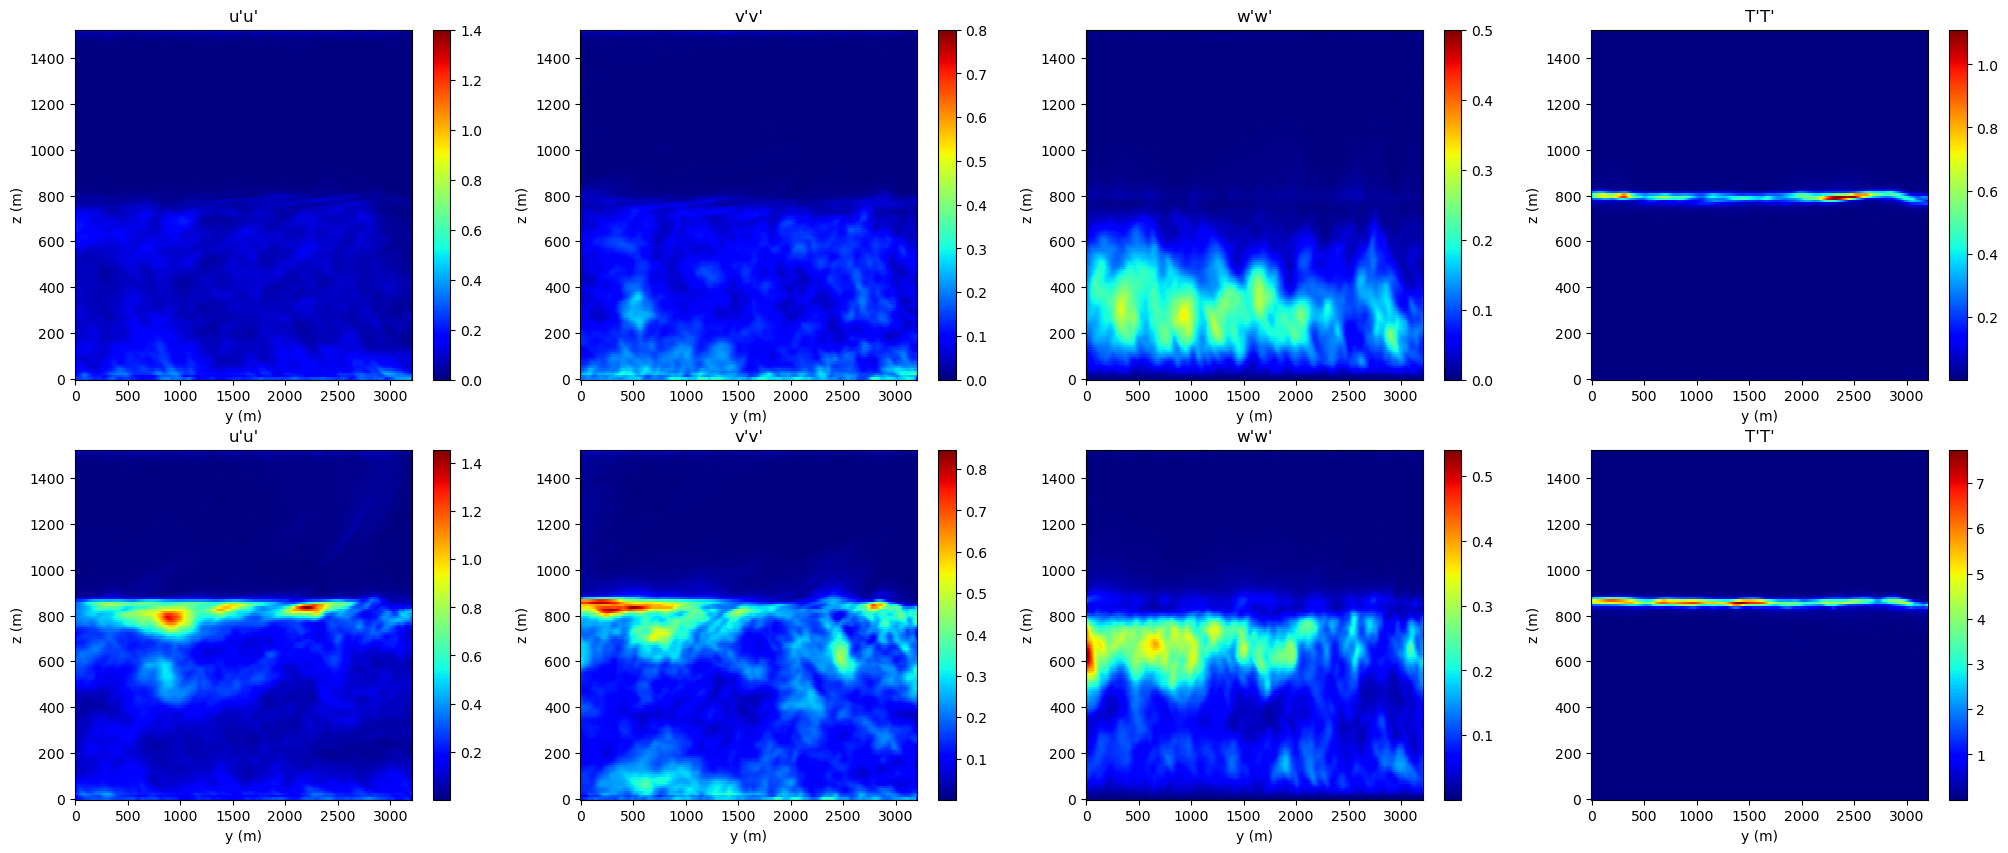

In [19]:
plt.rcParams['pcolor.shading'] = 'auto'
fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(25,10),squeeze=False)
cmap = plt.colormaps['jet']

yy_aw,zz_aw = np.meshgrid(ds_yz_x_1800_mi_po.y, ds_yz_x_1800_mi_po.z, indexing='ij')


uup_cont_nc = axs[0,0].pcolormesh(yy_aw, zz_aw, uup_nc, cmap=cmap)
axs[0,0].set_xlabel("y (m)")
axs[0,0].set_ylabel("z (m)")
axs[0,0].set_title("u'u'")
uup_cont_nc.set_clim(0, 1.4)
fig.colorbar(uup_cont_nc, ax=axs[0,0])

vvp_cont_nc = axs[0,1].pcolormesh(yy_aw, zz_aw, vvp_nc, cmap=cmap)
axs[0,1].set_xlabel("y (m)")
axs[0,1].set_ylabel("z (m)")
axs[0,1].set_title("v'v'")
vvp_cont_nc.set_clim(0, 0.8)
fig.colorbar(vvp_cont_nc, ax=axs[0,1])

wwp_cont_nc = axs[0,2].pcolormesh(yy_aw, zz_aw, wwp_nc, cmap=cmap)
axs[0,2].set_xlabel("y (m)")
axs[0,2].set_ylabel("z (m)")
axs[0,2].set_title("w'w'")
wwp_cont_nc.set_clim(0, 0.5)
fig.colorbar(wwp_cont_nc, ax=axs[0,2])

TTp_cont_nc = axs[0,3].pcolormesh(yy_aw, zz_aw, TTp_nc, cmap=cmap)
axs[0,3].set_xlabel("y (m)")
axs[0,3].set_ylabel("z (m)")
axs[0,3].set_title("T'T'")
#wwp_cont_nc.set_clim(0, 0.5)
fig.colorbar(TTp_cont_nc, ax=axs[0,3])

uup_cont = axs[1,0].pcolormesh(yy_aw, zz_aw, uup, cmap=cmap)
axs[1,0].set_xlabel("y (m)")
axs[1,0].set_ylabel("z (m)")
axs[1,0].set_title("u'u'")
fig.colorbar(uup_cont, ax=axs[1,0])

vvp_cont = axs[1,1].pcolormesh(yy_aw, zz_aw, vvp, cmap=cmap)
axs[1,1].set_xlabel("y (m)")
axs[1,1].set_ylabel("z (m)")
axs[1,1].set_title("v'v'")
fig.colorbar(vvp_cont, ax=axs[1,1])

wwp_cont = axs[1,2].pcolormesh(yy_aw, zz_aw, wwp, cmap=cmap)
axs[1,2].set_xlabel("y (m)")
axs[1,2].set_ylabel("z (m)")
axs[1,2].set_title("w'w'")
fig.colorbar(wwp_cont, ax=axs[1,2])

TTp_cont = axs[1,3].pcolormesh(yy_aw, zz_aw, TTp, cmap=cmap)
axs[1,3].set_xlabel("y (m)")
axs[1,3].set_ylabel("z (m)")
axs[1,3].set_title("T'T'")
#wwp_cont_nc.set_clim(0, 0.5)
fig.colorbar(TTp_cont, ax=axs[1,3])

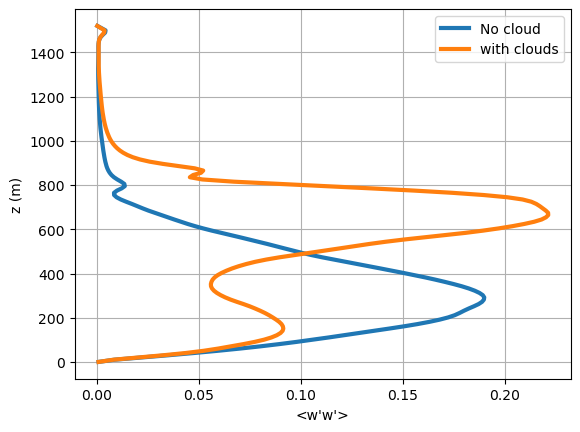

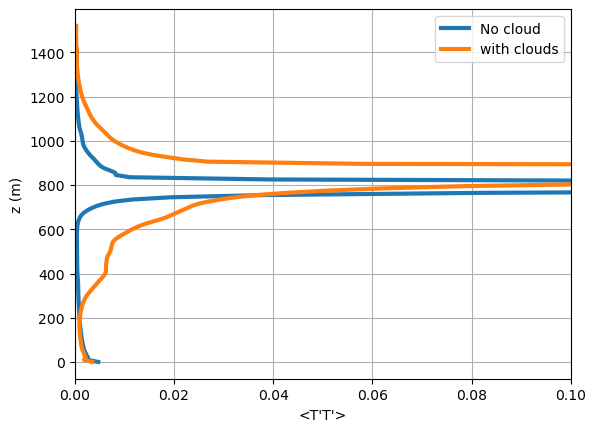

In [52]:
wwmean_vs_z = np.mean(wwp, axis=0)
wwmean_vs_z_nc = np.mean(wwp_nc, axis=0)
plt.figure()
plt.grid()
plt.plot(wwmean_vs_z_nc, ds_yz_x_1800_mi_po.z,linewidth=3, label='No cloud')
plt.plot(wwmean_vs_z, ds_yz_x_1800_mi_po.z,linewidth=3, label='with clouds')
plt.xlabel("<w'w'>")
plt.ylabel('z (m)')
plt.legend()

TTmean_vs_z = np.mean(TTp, axis=0)
TTmean_vs_z_nc = np.mean(TTp_nc, axis=0)
plt.figure()
plt.grid()
plt.plot(TTmean_vs_z_nc, ds_yz_x_1800_mi_po.z,linewidth=3, label='No cloud')
plt.plot(TTmean_vs_z, ds_yz_x_1800_mi_po.z,linewidth=3, label='with clouds')
plt.xlabel("<T'T'>")
plt.ylabel('z (m)')
plt.xlim(0, 0.1) 
plt.legend()


In [ ]:
# No clouds - 

In [21]:
ds_yz_x_1800_mi_po_nc_t2['uv'] = xr.cov(ds_yz_x_1800_mi_po_nc_t2['u'], ds_yz_x_1800_mi_po_nc_t2['v'], dim=['time']) 

In [22]:
ds_yz_x_1800_mi_po_nc_t2['uw'] = xr.cov(ds_yz_x_1800_mi_po_nc_t2['u'], ds_yz_x_1800_mi_po_nc_t2['w'], dim=['time']) 

In [23]:
ds_yz_x_1800_mi_po_nc_t2['vw'] = xr.cov(ds_yz_x_1800_mi_po_nc_t2['v'], ds_yz_x_1800_mi_po_nc_t2['w'], dim=['time']) 

In [32]:
ds_yz_x_1800_mi_po_nc_t2['uT'] = xr.cov(ds_yz_x_1800_mi_po_nc_t2['u'], ds_yz_x_1800_mi_po_nc_t2['T'], dim=['time']) 

In [33]:
ds_yz_x_1800_mi_po_nc_t2['vT'] = xr.cov(ds_yz_x_1800_mi_po_nc_t2['v'], ds_yz_x_1800_mi_po_nc_t2['T'], dim=['time']) 

In [34]:
ds_yz_x_1800_mi_po_nc_t2['wT'] = xr.cov(ds_yz_x_1800_mi_po_nc_t2['w'], ds_yz_x_1800_mi_po_nc_t2['T'], dim=['time']) 

In [28]:
uvp_nc = ds_yz_x_1800_mi_po_nc_t2['uv'][0,:,:]
uwp_nc = ds_yz_x_1800_mi_po_nc_t2['uw'][0,:,:]
vwp_nc = ds_yz_x_1800_mi_po_nc_t2['vw'][0,:,:]

In [38]:
uTp_nc = ds_yz_x_1800_mi_po_nc_t2['uT'][0,:,:]
vTp_nc = ds_yz_x_1800_mi_po_nc_t2['vT'][0,:,:]
wTp_nc = ds_yz_x_1800_mi_po_nc_t2['wT'][0,:,:]

In [ ]:
# With clouds - 

In [24]:
ds_yz_x_1800_mi_po['uv'] = xr.cov(ds_yz_x_1800_mi_po['u'], ds_yz_x_1800_mi_po['v'], dim=['time']) 

In [25]:
ds_yz_x_1800_mi_po['uw'] = xr.cov(ds_yz_x_1800_mi_po['u'], ds_yz_x_1800_mi_po['w'], dim=['time']) 

In [26]:
ds_yz_x_1800_mi_po['vw'] = xr.cov(ds_yz_x_1800_mi_po['v'], ds_yz_x_1800_mi_po['w'], dim=['time']) 

In [35]:
ds_yz_x_1800_mi_po['uT'] = xr.cov(ds_yz_x_1800_mi_po['u'], ds_yz_x_1800_mi_po['T'], dim=['time']) 

In [36]:
ds_yz_x_1800_mi_po['vT'] = xr.cov(ds_yz_x_1800_mi_po['v'], ds_yz_x_1800_mi_po['T'], dim=['time']) 

In [37]:
ds_yz_x_1800_mi_po['wT'] = xr.cov(ds_yz_x_1800_mi_po['w'], ds_yz_x_1800_mi_po['T'], dim=['time']) 

In [29]:
uvp = ds_yz_x_1800_mi_po['uv'][0,:,:]
uwp = ds_yz_x_1800_mi_po['uw'][0,:,:]
vwp = ds_yz_x_1800_mi_po['vw'][0,:,:]

In [39]:
uTp = ds_yz_x_1800_mi_po['uT'][0,:,:]
vTp = ds_yz_x_1800_mi_po['vT'][0,:,:]
wTp = ds_yz_x_1800_mi_po['wT'][0,:,:]

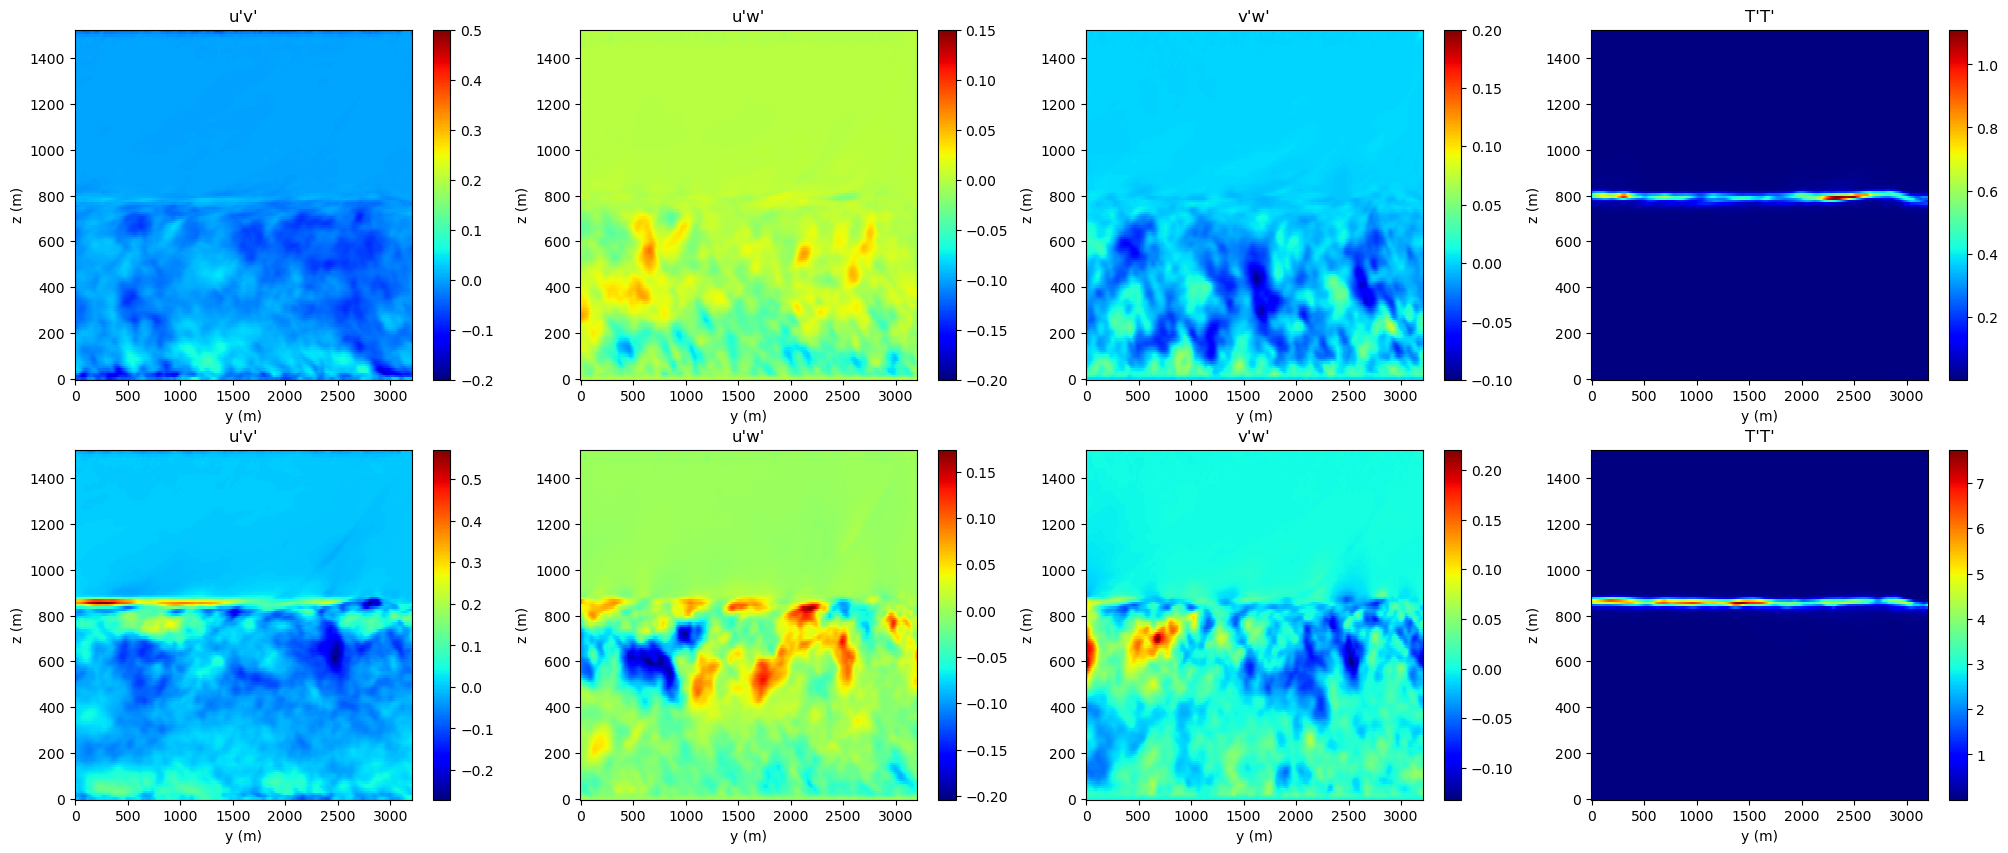

In [31]:
plt.rcParams['pcolor.shading'] = 'auto'
fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(25,10),squeeze=False)
cmap = plt.colormaps['jet']

yy_aw,zz_aw = np.meshgrid(ds_yz_x_1800_mi_po.y, ds_yz_x_1800_mi_po.z, indexing='ij')


uvp_cont_nc = axs[0,0].pcolormesh(yy_aw, zz_aw, uvp_nc, cmap=cmap)
axs[0,0].set_xlabel("y (m)")
axs[0,0].set_ylabel("z (m)")
axs[0,0].set_title("u'v'")
uvp_cont_nc.set_clim(-0.2, 0.5)
fig.colorbar(uvp_cont_nc, ax=axs[0,0])

uwp_cont_nc = axs[0,1].pcolormesh(yy_aw, zz_aw, uwp_nc, cmap=cmap)
axs[0,1].set_xlabel("y (m)")
axs[0,1].set_ylabel("z (m)")
axs[0,1].set_title("u'w'")
uwp_cont_nc.set_clim(-0.2, 0.15)
fig.colorbar(uwp_cont_nc, ax=axs[0,1])

vwp_cont_nc = axs[0,2].pcolormesh(yy_aw, zz_aw, vwp_nc, cmap=cmap)
axs[0,2].set_xlabel("y (m)")
axs[0,2].set_ylabel("z (m)")
axs[0,2].set_title("v'w'")
vwp_cont_nc.set_clim(-0.1, 0.2)
fig.colorbar(vwp_cont_nc, ax=axs[0,2])

TTp_cont_nc = axs[0,3].pcolormesh(yy_aw, zz_aw, TTp_nc, cmap=cmap)
axs[0,3].set_xlabel("y (m)")
axs[0,3].set_ylabel("z (m)")
axs[0,3].set_title("T'T'")
#wwp_cont_nc.set_clim(0, 0.5)
fig.colorbar(TTp_cont_nc, ax=axs[0,3])

uvp_cont = axs[1,0].pcolormesh(yy_aw, zz_aw, uvp, cmap=cmap)
axs[1,0].set_xlabel("y (m)")
axs[1,0].set_ylabel("z (m)")
axs[1,0].set_title("u'v'")
fig.colorbar(uvp_cont, ax=axs[1,0])

uwp_cont = axs[1,1].pcolormesh(yy_aw, zz_aw, uwp, cmap=cmap)
axs[1,1].set_xlabel("y (m)")
axs[1,1].set_ylabel("z (m)")
axs[1,1].set_title("u'w'")
fig.colorbar(uwp_cont, ax=axs[1,1])

vwp_cont = axs[1,2].pcolormesh(yy_aw, zz_aw, vwp, cmap=cmap)
axs[1,2].set_xlabel("y (m)")
axs[1,2].set_ylabel("z (m)")
axs[1,2].set_title("v'w'")
fig.colorbar(vwp_cont, ax=axs[1,2])

TTp_cont = axs[1,3].pcolormesh(yy_aw, zz_aw, TTp, cmap=cmap)
axs[1,3].set_xlabel("y (m)")
axs[1,3].set_ylabel("z (m)")
axs[1,3].set_title("T'T'")
#wwp_cont_nc.set_clim(0, 0.5)
fig.colorbar(TTp_cont, ax=axs[1,3])

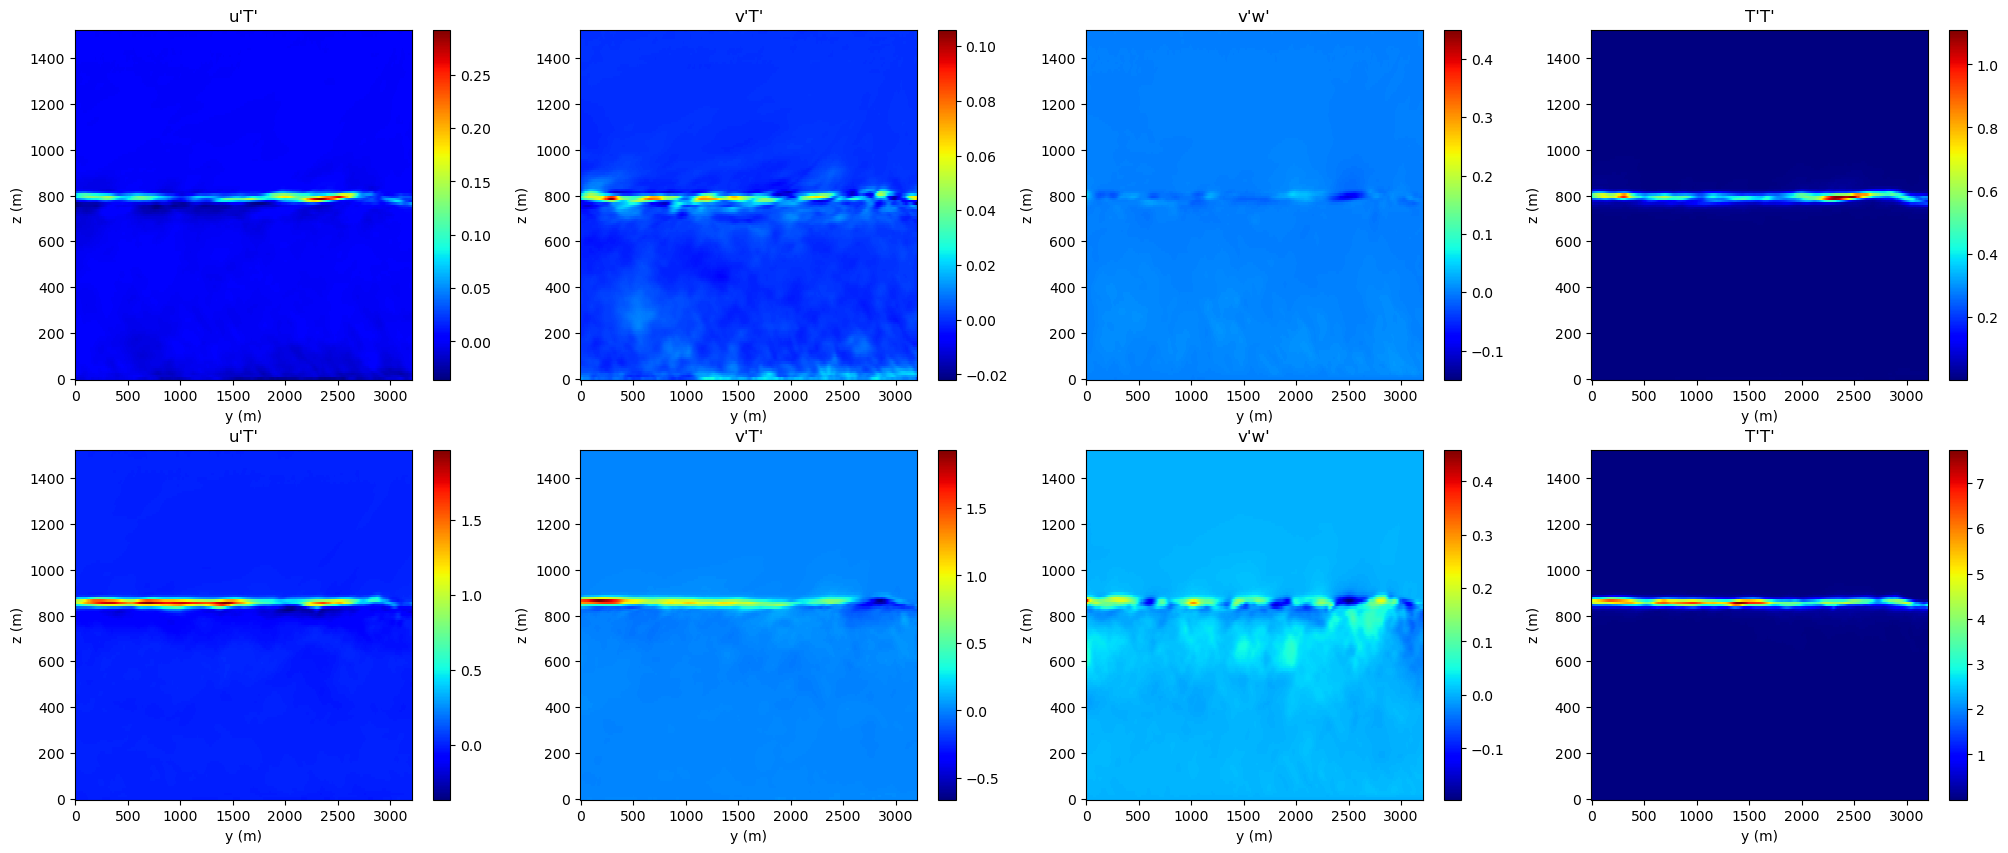

In [42]:
plt.rcParams['pcolor.shading'] = 'auto'
fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(25,10),squeeze=False)
cmap = plt.colormaps['jet']

yy_aw,zz_aw = np.meshgrid(ds_yz_x_1800_mi_po.y, ds_yz_x_1800_mi_po.z, indexing='ij')


uTp_cont_nc = axs[0,0].pcolormesh(yy_aw, zz_aw, uTp_nc, cmap=cmap)
axs[0,0].set_xlabel("y (m)")
axs[0,0].set_ylabel("z (m)")
axs[0,0].set_title("u'T'")
#uvp_cont_nc.set_clim(-0.2, 0.5)
fig.colorbar(uTp_cont_nc, ax=axs[0,0])

vTp_cont_nc = axs[0,1].pcolormesh(yy_aw, zz_aw, vTp_nc, cmap=cmap)
axs[0,1].set_xlabel("y (m)")
axs[0,1].set_ylabel("z (m)")
axs[0,1].set_title("v'T'")
#vTp_cont_nc.set_clim(-0.2, 0.15)
fig.colorbar(vTp_cont_nc, ax=axs[0,1])

wTp_cont_nc = axs[0,2].pcolormesh(yy_aw, zz_aw, wTp_nc, cmap=cmap)
axs[0,2].set_xlabel("y (m)")
axs[0,2].set_ylabel("z (m)")
axs[0,2].set_title("v'w'")
wTp_cont_nc.set_clim(-0.15, 0.45)
fig.colorbar(wTp_cont_nc, ax=axs[0,2])

TTp_cont_nc = axs[0,3].pcolormesh(yy_aw, zz_aw, TTp_nc, cmap=cmap)
axs[0,3].set_xlabel("y (m)")
axs[0,3].set_ylabel("z (m)")
axs[0,3].set_title("T'T'")
#wwp_cont_nc.set_clim(0, 0.5)
fig.colorbar(TTp_cont_nc, ax=axs[0,3])

uTp_cont = axs[1,0].pcolormesh(yy_aw, zz_aw, uTp, cmap=cmap)
axs[1,0].set_xlabel("y (m)")
axs[1,0].set_ylabel("z (m)")
axs[1,0].set_title("u'T'")
fig.colorbar(uTp_cont, ax=axs[1,0])

vTp_cont = axs[1,1].pcolormesh(yy_aw, zz_aw, vTp, cmap=cmap)
axs[1,1].set_xlabel("y (m)")
axs[1,1].set_ylabel("z (m)")
axs[1,1].set_title("v'T'")
fig.colorbar(vTp_cont, ax=axs[1,1])

wTp_cont = axs[1,2].pcolormesh(yy_aw, zz_aw, wTp, cmap=cmap)
axs[1,2].set_xlabel("y (m)")
axs[1,2].set_ylabel("z (m)")
axs[1,2].set_title("v'w'")
fig.colorbar(wTp_cont, ax=axs[1,2])

TTp_cont = axs[1,3].pcolormesh(yy_aw, zz_aw, TTp, cmap=cmap)
axs[1,3].set_xlabel("y (m)")
axs[1,3].set_ylabel("z (m)")
axs[1,3].set_title("T'T'")
#wwp_cont_nc.set_clim(0, 0.5)
fig.colorbar(TTp_cont, ax=axs[1,3])

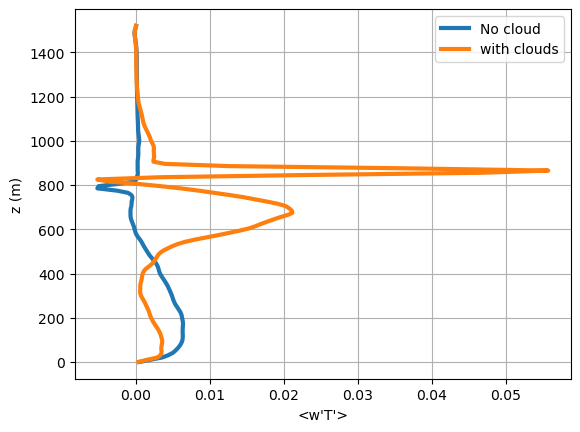

In [48]:
wTp_vs_z = np.mean(wTp, axis=0)
wTp_vs_z_nc = np.mean(wTp_nc, axis=0)
plt.figure()
plt.grid()
plt.plot(wTp_vs_z_nc, ds_yz_x_1800_mi_po.z,linewidth=3, label='No cloud')
plt.plot(wTp_vs_z, ds_yz_x_1800_mi_po.z,linewidth=3, label='with clouds')
plt.xlabel("<w'T'>")
plt.ylabel('z (m)')
plt.legend()